In [2]:
import xarray as xr
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import gsw
import os
from mpl_toolkits.mplot3d import Axes3D
from salishsea_tools import viz_tools
from scipy.optimize import curve_fit
from datetime import datetime, timedelta
from matplotlib import animation
from IPython.display import HTML

%matplotlib inline

In [26]:
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
grid = xr.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)

### Build idealized basin, islands, and channels

In [27]:
# Build coordinates
j, i = bathy.Bathymetry.shape
x = np.arange(i)
y = np.arange(j)
x, y = np.meshgrid(x, y, indexing='xy')

# Make main basin
z = -1 * (np.cosh((x - 200)/12)*20 + np.cosh((y - 550)/35)) + 400

# Add Texada island
zz = z - 1000 * np.exp(-((x - 210)/10)**2 - ((y - 610)/40)**2)

# Add channel
zz = zz + 20000 * np.exp(-((x - 84.7)/33.1)**2 - ((y - 620)/15)**2)

# Add channel
zz = zz + 10000 * np.exp(-((x - 317)/40)**2 - ((y - 770)/8)**2)

# Add channel
zz = zz + 1200 * np.exp(-((x - 220)/10)**2 - ((y - 850)/50)**2)

# Add small island
zz = zz - 500 * np.exp(-((x - 158)/6)**2 - ((y - 620)/6)**2)

# Add small island
zz = zz - 500 * np.exp(-((x - 220)/6)**2 - ((y - 770)/6)**2)

# Trim negative points as land
z[z < 0] = 0
zz[zz < 0] = 0

### Visualize
**Cross-section**

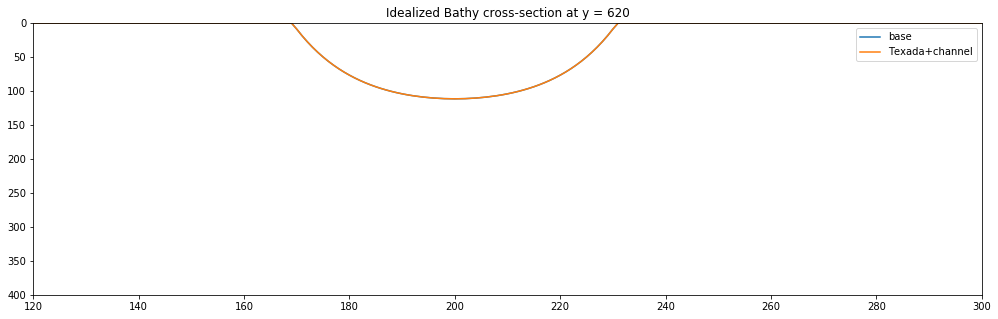

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax.plot(z[770, :], label='base')
ax.plot(zz[770, :], label='Texada+channel')
ax.set_xlim([120, 300])
ax.set_ylim([400, 0])
ax.set_title('Idealized Bathy cross-section at y = 620')
ax.legend()

**Wire mesh**

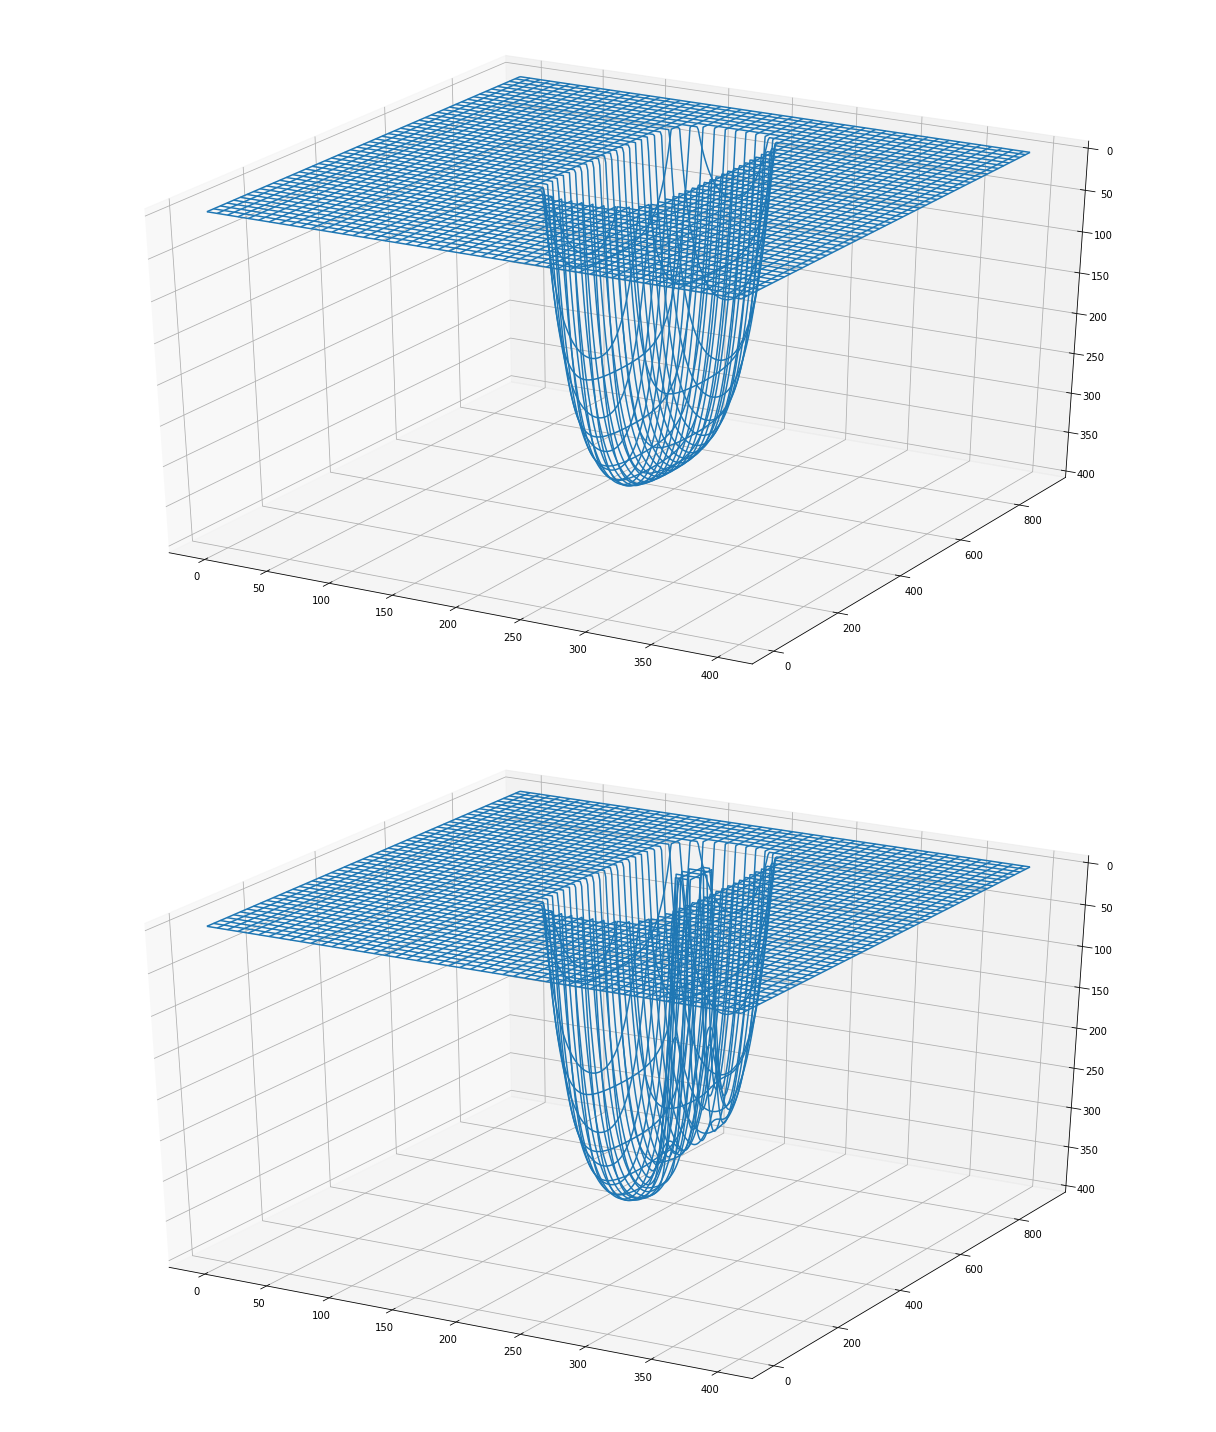

In [6]:
fig = plt.figure(figsize=(17, 20))
for col, Z in zip([1, 2], [z, zz]):
    ax = fig.add_subplot(2, 1, col, projection='3d')
    ax.plot_wireframe(x, y, Z)
    ax.set_zlim([400, 0])

fig.tight_layout()
plt.show()

**Plan view**

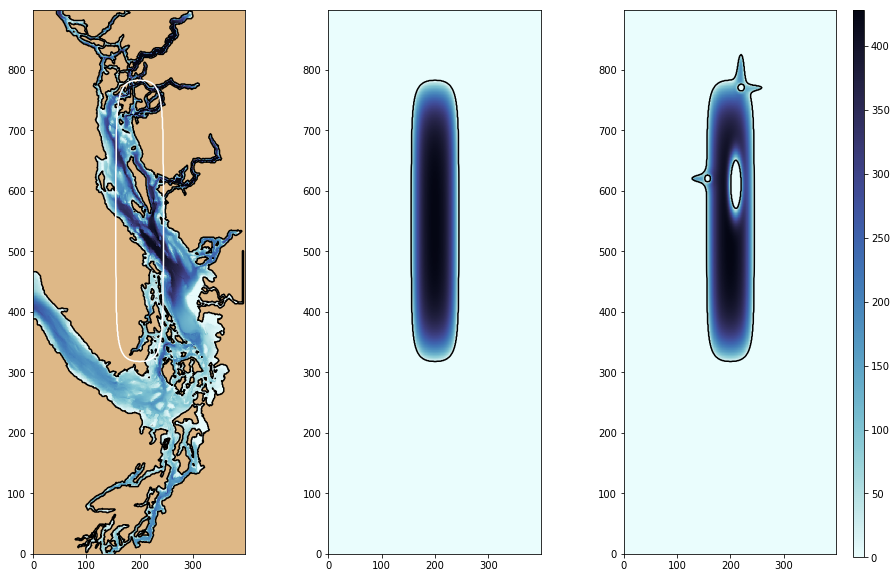

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
for ax in axs:
    ax.set_xlim([0, 398])
    ax.set_ylim([0, 898])
    viz_tools.set_aspect(ax)

c = axs[0].pcolormesh(bathy.Bathymetry, cmap=cmocean.cm.ice_r)
axs[0].contourf(bathy.Bathymetry, levels=[-0.01, 0.01], colors='burlywood')
axs[0].contour(bathy.Bathymetry, levels=[-0.01, 0.01], colors='k')
axs[0].contour(z, levels=1, colors='w')

axs[1].pcolormesh(z, cmap=cmocean.cm.ice_r)
axs[1].contour(z, levels=1, colors='k')

axs[2].pcolormesh(zz, cmap=cmocean.cm.ice_r)
axs[2].contour(zz, levels=1, colors='k')

cax = fig.add_axes([0.9, 0.12, 0.01, 0.76])
fig.colorbar(c, cax=cax)

### Save new pond bathy to netCDF

In [29]:
# Define subdomain lims
#xrange = [127, 260]
#yrange = [315, 827]

# Update bathy field and grid and save to netCDF
bathy.update({'Bathymetry': (['y', 'x'], zz)}).to_netcdf('/data/bmoorema/MEOPAR/grid/idealized/bathymetry_pond_all.nc')
#grid.isel(y=slice(*yrange), x=slice(*xrange)).to_netcdf('/data/bmoorema/MEOPAR/grid/idealized/coordinates_seagrid_pond.nc', engine='scipy')

### Initial stratification
Define fit functions

In [11]:
def expfit(z, a, b, c, d):
    """Simple exponential fit functions
    """
    
    return a * np.exp(-b * z) + c * z + d

In [12]:
def rho_from_N2(z, a, b, c, d):
    """Rho integrated from N2 exponential fit
    -rho_0 / g * result + rho(z=0)
    """
    
    return a / b * (1 - np.exp(-b * z)) + c / 2 * z**2 + d * z

Spatially average T and S climatologies, calc $\rho$ and N$^2$, fit N$^2$ and CT to exponentials and calc $\rho$ and SA

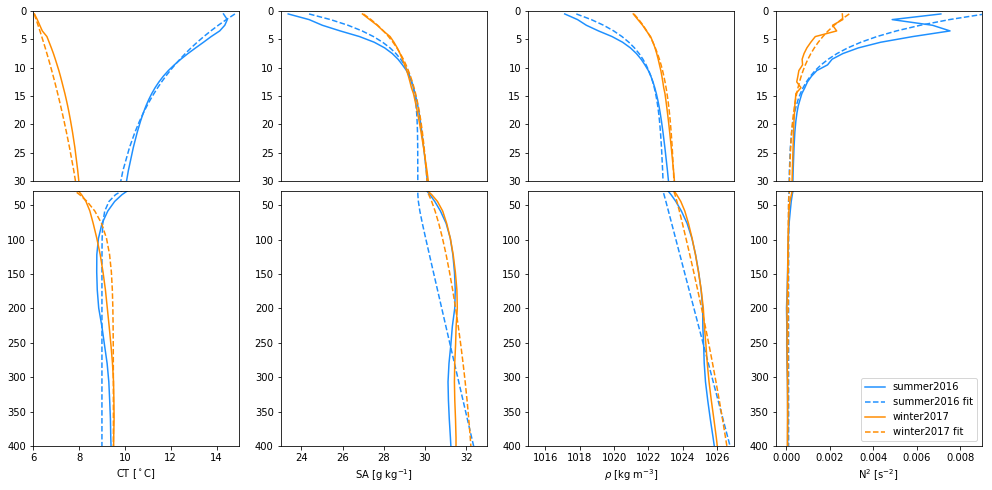

In [13]:
xrange = [0, 398]
yrange = [0, 898]

# Physical parameters
g = -9.81
rho_0 = 1030

# Initialize raw averages dict
raw = {'summer2016': {}, 'winter2017': {}}

# Initialize fits dict with fit params and labels
fits = {
    'summer2016': {
        'params': {
            'CT': (6, 1/15, 0, 9),
            'N2': (0.01, 1/5, 0, 1e-4),
            'rho_surf': 1017.3,
        },
    },
    'winter2017': {
        'params': {
            'CT': (-3.5, 1/40, 0, 9.5),
            'N2': (0.003, 1/7, -1e-7, 1e-4),
            'rho_surf': 1021.0,
        },
    },
    'labels': {
        'CT': 'CT [$^\circ$C]',
        'SA': 'SA [g kg$^{-1}$]',
        'rho': '$\\rho$ [kg m$^{-3}$]',
        'N2': 'N$^2$ [s$^{-2}$]',
    },
}

# Make figure grid
fig, axs = plt.subplots(2, 4, figsize=(17, 8), gridspec_kw={'height_ratios': [2, 3], 'hspace': 0.05})

# Loop through seasons
for season, color in zip(['summer2016', 'winter2017'], ['dodgerblue', 'darkorange']):
    
    # Extract CT and SA
    filename = f'/data/bmoorema/MEOPAR/tracers/initial/{season}_201702.nc'
    data = xr.open_dataset(filename).isel(x=slice(*xrange), y=slice(*yrange))
    z = data.deptht
    raw[season]['SA'] = np.ma.masked_values(data.vosaline, 0).mean(axis=(1, 2)).data
    raw[season]['CT'] = np.ma.masked_values(data.votemper, 0).mean(axis=(1, 2)).data
    
    # Calc rho and N2
    raw[season]['rho'] = gsw.rho(raw[season]['SA'], raw[season]['CT'], z)
    raw[season]['N2'] = -g / rho_0 * np.diff(raw[season]['rho']) / np.diff(z)
    N2_deep = raw[season]['N2'][-2]
    raw[season]['N2'] = np.append(raw[season]['N2'][:-1], [N2_deep, N2_deep])
    
    # Fit N2 and CT to exponentials, calc rho and SA
    fits[season]['N2'] = expfit(z, *fits[season]['params']['N2'])
    fits[season]['CT'] = expfit(z, *fits[season]['params']['CT'])
    fits[season]['rho'] = -rho_0 / g * rho_from_N2(z, *fits[season]['params']['N2']) + fits[season]['params']['rho_surf']
    fits[season]['SA'] = gsw.SA_from_rho(fits[season]['rho'], fits[season]['CT'], z)
    
    # Plot curves
    for row, ylim in zip(axs, ([30, 0], [400, 30])):
        for ax, key, xlim in zip(row, ['CT', 'SA', 'rho', 'N2'], ([6, 15], [23, 33], [1015, 1027], [-0.0005, 0.009])):
            ax.plot(raw[season][key], z, label=season, color=color)
            ax.plot(fits[season][key], z, '--', label=f'{season} fit', color=color)
            ax.set_ylim(ylim)
            ax.set_xlim(xlim)
            if ylim[1] == 0:
                ax.xaxis.set_ticks([])
            else:
                ax.set_xlabel(fits['labels'][key])

    # Export new initialization fields to file
    data.update({
        'votemper': (
            ['deptht', 'y', 'x'],
            np.ones(data.votemper.shape) * fits[season]['CT'].values[:, np.newaxis, np.newaxis],
        ),
        'vosaline': (
            ['deptht', 'y', 'x'],
            np.ones(data.votemper.shape) * fits[season]['SA'][:, np.newaxis, np.newaxis],
        ),
    }).rename(
        {'votemper': 'tn', 'vosaline': 'sn'},
    ).to_netcdf(f'/data/bmoorema/MEOPAR/tracers/initial/idealized/{season}_pond.nc')
        
axs[1, 3].legend(loc=4)
plt.show()

### Results

In [5]:
results = {'summer': {'N': {}, 'S': {}}, 'winter': {'N': {}, 'S': {}}}
bathtype = 'basic'
for season in ['summer', 'winter']:
    for winddir in ['N', 'S']:
        for ftype in ['grid', 'ptrc']:
            runpath = os.path.join(
                '/data/bmoorema/MEOPAR/Results/SalishSeaPond',
                f'SalishSeaPond_{bathtype}_{season}_{winddir}24H',
                f'SalishSeaLake_1h_20170701_20170704_{ftype}_T.nc'
            )
            results[season][winddir][ftype] = xr.open_dataset(runpath)

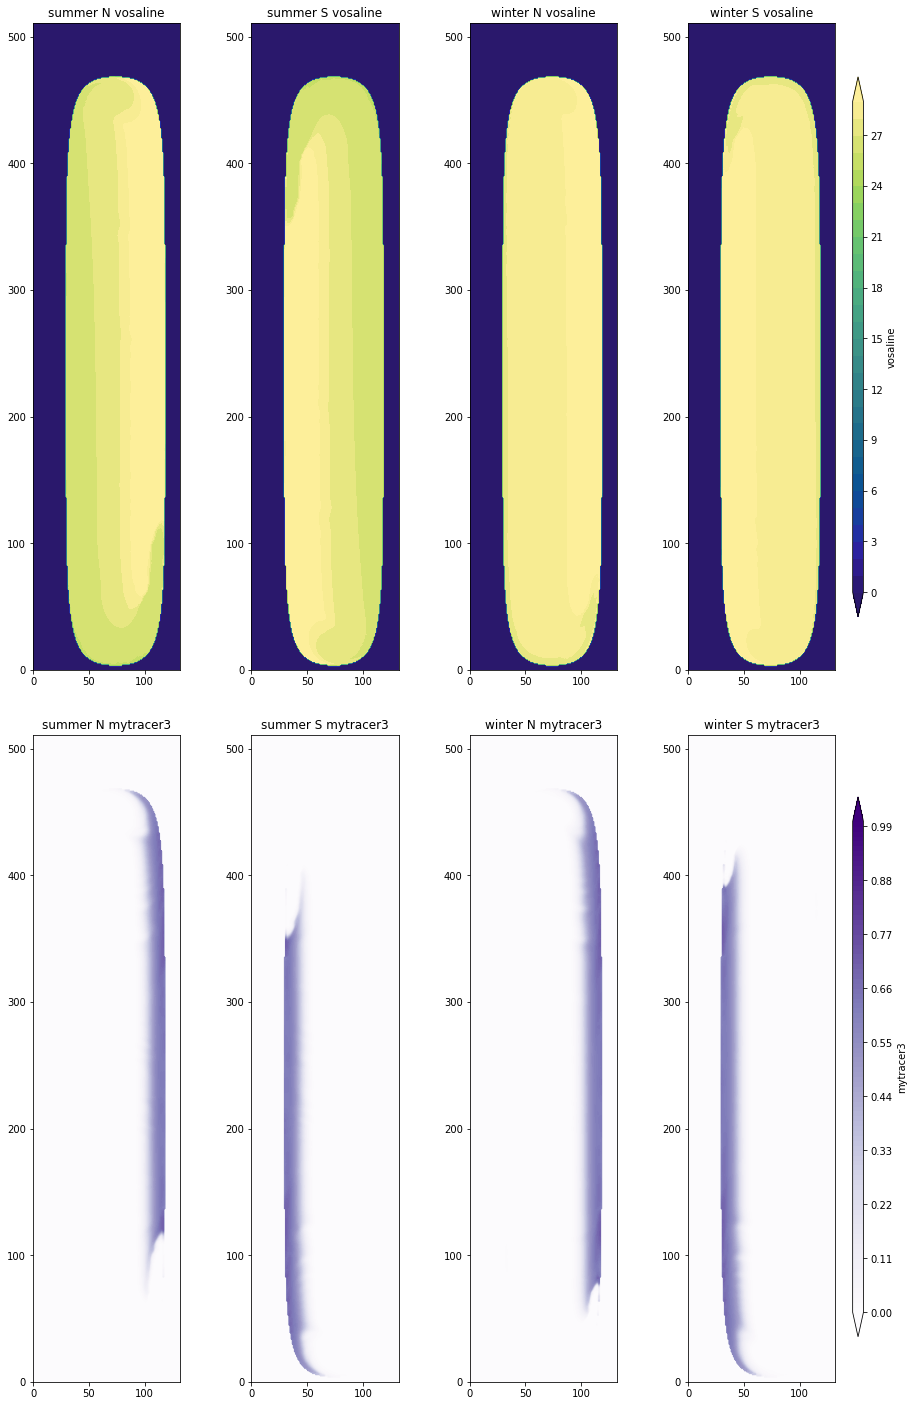

In [37]:
# Make figure window
fig, axs = plt.subplots(2, 4, figsize=(15, 25), gridspec_kw={'hspace': 0.1})
C = {}
for row, ftype, qty, levels, cmap, cbar in zip(
    axs, ['grid', 'ptrc'], ['vosaline', 'mytracer3'],
    [range(30), np.arange(0, 1.01, 0.01)], [cmocean.cm.haline, 'Purples'], [0.55, 0.15]
):
    for ax_pair, season in zip(row.reshape((2, 2)), ['summer', 'winter']):
        for ax, winddir in zip(ax_pair, ['N', 'S']):
            C[qty] = ax.contourf(
                results[season][winddir][ftype][qty][50, 0, ...],
                cmap=cmap, levels=levels, extend='both',
            )
            timestamp = results[season][winddir][ftype].time_counter[0]
            timestamp = timestamp.values.astype('datetime64[s]').astype(datetime).strftime('%Y %b %d %H:%M')
            #txt = ax.text(0.02, 1.02, timestamp, transform=ax.transAxes)
            viz_tools.set_aspect(ax)
            ax.set_title(f'{season} {winddir} {qty}')


    # Colorbar
    cax = fig.add_axes([0.9, cbar, 0.01, 0.3])
    fig.colorbar(C[qty], cax=cax, label=qty)
    
def next_frame(t):

    # Update figure
    for row, ftype, qty, levels, cmap, cbar in zip(
        axs, ['grid', 'ptrc'], ['vosaline', 'mytracer3'],
        [range(30), np.arange(0, 1.01, 0.01)], [cmocean.cm.haline, 'Purples'], [0.55, 0.15]
    ):
        for ax_pair, season in zip(row.reshape((2, 2)), ['summer', 'winter']):
            for ax, winddir in zip(ax_pair, ['N', 'S']):
                C[qty] = ax.contourf(
                    results[season][winddir][ftype][qty][t, 0, ...],
                    cmap=cmap, levels=levels, extend='both',
                )
    
    return

# Animate
#anim = animation.FuncAnimation(fig, next_frame, frames=10)

In [35]:
#HTML(anim.to_html5_video())